Rough work and experimentations


In [8]:
import cv2
import numpy as np
import os

def detect_hair_length(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define hair color range in HSV
    lower_hair = np.array([0, 10, 0])  # Adjust these values
    upper_hair = np.array([179, 255, 80])  # Adjust these values
    
    # Create a mask for hair color
    mask = cv2.inRange(hsv, lower_hair, upper_hair)
    
    # Apply morphological operations to remove noise
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of the largest contour (assumed to be hair)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        hair_area = cv2.contourArea(max_contour)
        
        # Use the area to decide if the hair is long or short
        if hair_area > 1000:  # Threshold for long hair, adjust as needed
            return "long"
        else:
            return "short"
    
    return "unknown"

# Directory paths
input_dir = r'temp'
long_hair_dir = r'long hair'
short_hair_dir = r'short hair'

# Ensure output directories exist
os.makedirs(long_hair_dir, exist_ok=True)
os.makedirs(short_hair_dir, exist_ok=True)

# Process images
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_dir, filename)
        hair_length = detect_hair_length(image_path)
        if hair_length == 'long':
            cv2.imwrite(os.path.join(long_hair_dir, filename), cv2.imread(image_path))
        elif hair_length == 'short':
            cv2.imwrite(os.path.join(short_hair_dir, filename), cv2.imread(image_path))


In [7]:
import os
from shutil import move

# Paths
input_dir = r'utkface subset' # Replace with your actual input directory path
output_dir = r'C:\prabhakar\null classes\long hair detection\temp'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process images
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg'):  # Or any other image extension used in your dataset
        image_path = os.path.join(input_dir, filename)

        # Extract age from filename (assuming UTKFace naming convention)
        age = int(filename.split('_')[0])

        # Filter images based on age range
        if 20 <= age <= 30:
            # Move the image to the output directory
            move(image_path, output_dir)


In [23]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Function to load images from a directory and assign a label to them
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))  # Resize all images to 64x64 pixels
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load images for short hair (label: 0) and long hair (label: 1)
short_hair_images, short_hair_labels = load_images_from_directory('short hair', 0)
long_hair_images, long_hair_labels = load_images_from_directory('long hair', 1)

# Load images for general gender classification (labels will be dataset-specific)
gender_images, gender_labels = load_images_from_directory('utkface subset', 0)

# Combine short and long hair datasets
hair_images = np.concatenate([short_hair_images, long_hair_images], axis=0)
hair_labels = np.concatenate([short_hair_labels, long_hair_labels], axis=0)

# Split hair data into training and testing sets (80% training, 20% testing)
X_train_hair, X_test_hair, y_train_hair, y_test_hair = train_test_split(hair_images, hair_labels, test_size=0.2, random_state=42)

# Split general gender data into training and testing sets (80% training, 20% testing)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(gender_images, gender_labels, test_size=0.2, random_state=42)

# Normalize image data to the range [0, 1]
X_train_hair, X_test_hair = X_train_hair / 255.0, X_test_hair / 255.0
X_train_gender, X_test_gender = X_train_gender / 255.0, X_test_gender / 255.0


In [41]:

# Function to build the hair length classification model
def build_hair_length_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification: short hair (0) vs long hair (1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [42]:

# Function to build the gender classification model
def build_gender_classification_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Assuming binary gender classification: male (0) vs female (1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [50]:

# Build and compile the hair length classification model
hair_length_model = build_hair_length_model()

# Define callbacks for the hair length model
hair_checkpoint = ModelCheckpoint('best_hair_length_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
hair_early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, mode='max')

# Train the hair length model
hair_model_history = hair_length_model.fit(X_train_hair, y_train_hair, epochs=30, validation_data=(X_test_hair, y_test_hair),
                     callbacks=[hair_checkpoint, hair_early_stopping])

# Build and compile the gender classification model
gender_classification_model = build_gender_classification_model()

# Define callbacks for the gender classification model
gender_checkpoint = ModelCheckpoint('best_gender_classification_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
gender_early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

# Train the gender classification model
gender_model_history = gender_classification_model.fit(X_train_gender, y_train_gender, epochs=20, validation_data=(X_test_gender, y_test_gender),
                                callbacks=[gender_checkpoint, gender_early_stopping])




Epoch 1/30
34/34 [==============================] - 1s 15ms/step - loss: 0.6876 - accuracy: 0.6116 - val_loss: 0.6016 - val_accuracy: 0.6324
Epoch 2/30
34/34 [==============================] - 0s 10ms/step - loss: 0.4709 - accuracy: 0.7860 - val_loss: 0.3770 - val_accuracy: 0.8419
Epoch 3/30
34/34 [==============================] - 0s 10ms/step - loss: 0.3866 - accuracy: 0.8496 - val_loss: 0.3465 - val_accuracy: 0.8493
Epoch 4/30
34/34 [==============================] - 0s 9ms/step - loss: 0.3323 - accuracy: 0.8736 - val_loss: 0.3603 - val_accuracy: 0.8346
Epoch 5/30
34/34 [==============================] - 0s 9ms/step - loss: 0.3213 - accuracy: 0.8782 - val_loss: 0.3209 - val_accuracy: 0.8493
Epoch 6/30
34/34 [==============================] - 0s 10ms/step - loss: 0.2855 - accuracy: 0.8884 - val_loss: 0.2812 - val_accuracy: 0.8787
Epoch 7/30
34/34 [==============================] - 0s 9ms/step - loss: 0.2449 - accuracy: 0.9041 - val_loss: 0.3205 - val_accuracy: 0.8603
Epoch 8/30
34/34

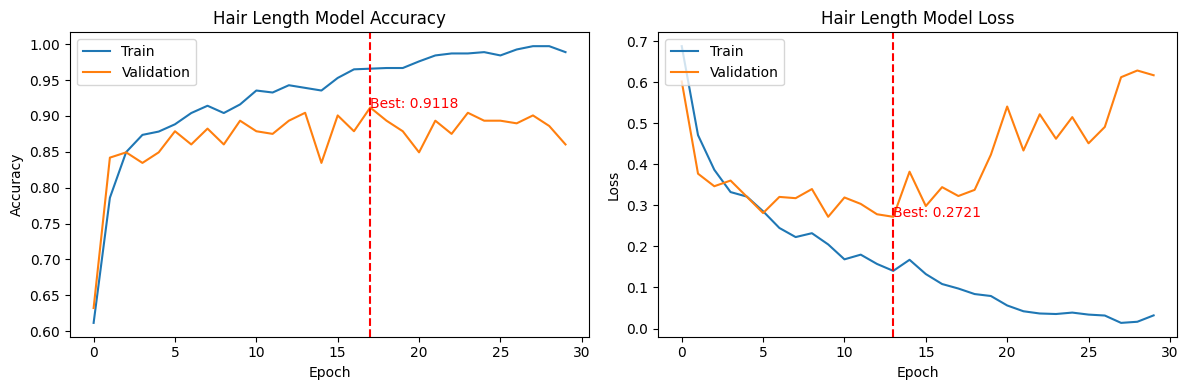

Hair Length Model - Best Validation Accuracy: 0.9118 at epoch 18
Hair Length Model - Best Validation Loss: 0.2721 at epoch 14


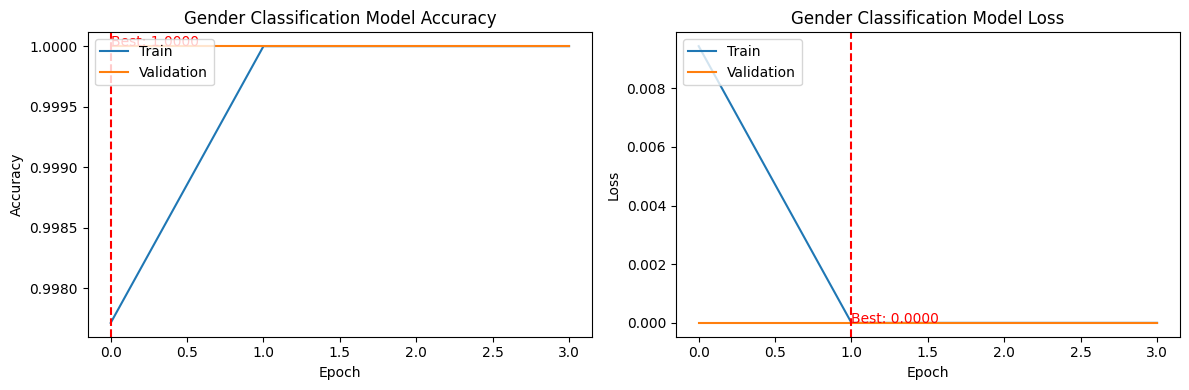

Gender Classification Model - Best Validation Accuracy: 1.0000 at epoch 1
Gender Classification Model - Best Validation Loss: 0.0000 at epoch 2


In [51]:
import matplotlib.pyplot as plt

# Function to plot metrics and highlight best points
def plot_training_history(history, model_name):
  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'{model_name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Highlight best validation accuracy
  best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
  best_val_acc = history.history['val_accuracy'][best_val_acc_epoch]
  plt.axvline(x=best_val_acc_epoch, color='r', linestyle='--')
  plt.text(best_val_acc_epoch, best_val_acc, f'Best: {best_val_acc:.4f}', color='r')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'{model_name} Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Highlight best validation loss
  best_val_loss_epoch = np.argmin(history.history['val_loss'])
  best_val_loss = history.history['val_loss'][best_val_loss_epoch]
  plt.axvline(x=best_val_loss_epoch, color='r', linestyle='--')
  plt.text(best_val_loss_epoch, best_val_loss, f'Best: {best_val_loss:.4f}', color='r')

  plt.tight_layout()
  plt.show()

  # Print best validation accuracy and loss
  print(f"{model_name} - Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch + 1}")
  print(f"{model_name} - Best Validation Loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch + 1}")

# Plot for hair length model
plot_training_history(hair_model_history, "Hair Length Model")

# Plot for gender classification model
plot_training_history(gender_model_history, "Gender Classification Model")


In [52]:
# Evaluate the hair length classification model on the test set
hair_test_loss, hair_test_accuracy = hair_length_model.evaluate(X_test_hair, y_test_hair)
print(f'Hair Length Model Test Accuracy: {hair_test_accuracy * 100:.2f}%')

# Evaluate the gender classification model on the test set
gender_test_loss, gender_test_accuracy = gender_classification_model.evaluate(X_test_gender, y_test_gender)
print(f'Gender Classification Model Test Accuracy: {gender_test_accuracy * 100:.2f}%')



9/9 [==============================] - 0s 25ms/step - loss: 0.6168 - accuracy: 0.8603
Hair Length Model Test Accuracy: 86.03%
21/21 [==============================] - 0s 4ms/step - loss: 4.5083e-34 - accuracy: 1.0000
Gender Classification Model Test Accuracy: 100.00%


In [53]:
# Save the final versions of the trained models (best weights already saved)
hair_length_model.save('final_hair_length_model.h5')
gender_classification_model.save('final_gender_classification_model.h5')

In [54]:
#age model

In [74]:
def load_images_with_age(directory):
    images = []
    ages = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))  # Resize all images to 64x64
            # Assuming the filename contains the age (e.g., "23_0_0_20170117181452778.jpg")
            age = int(filename.split('_')[0])
            images.append(img)
            ages.append(age)
    return np.array(images), np.array(ages)

# Load images and ages from the UTKFace subset
age_images, age_labels = load_images_with_age('utkface subset')

# Normalize image data
age_images = age_images / 255.0

# Split the data into training and testing sets
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(age_images, age_labels, test_size=0.2, random_state=42)


In [75]:



from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_age_prediction_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer='l2'),
        Dropout(0.5),
        Dense(1, activation='linear')  # Output layer for age prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

age_model = build_age_prediction_model()

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

age_model.fit(X_train_age, y_train_age, epochs=100, validation_data=(X_test_age, y_test_age),
              callbacks=[early_stopping, reduce_lr])


Epoch 1/100
82/82 [==============================] - 2s 12ms/step - loss: 434.9311 - mae: 16.1963 - val_loss: 2285.1963 - val_mae: 41.7657 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 1s 10ms/step - loss: 250.7452 - mae: 12.0667 - val_loss: 852.8322 - val_mae: 23.2796 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 1s 10ms/step - loss: 202.5706 - mae: 10.7672 - val_loss: 545.5225 - val_mae: 18.5927 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 1s 10ms/step - loss: 157.0671 - mae: 9.3633 - val_loss: 350.2252 - val_mae: 14.0194 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 1s 10ms/step - loss: 141.2158 - mae: 8.8270 - val_loss: 431.1302 - val_mae: 15.5455 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 1s 10ms/step - loss: 117.4873 - mae: 8.0170 - val_loss: 433.8887 - val_mae: 15.5100 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 1s 10ms/step - loss: 102.1343 - mae: 7.4355

In [76]:
# # Load the best weights
age_model.load_weights('best_age_prediction_model.h5')

# Evaluate age prediction model with the best weights
age_loss, age_mae = age_model.evaluate(X_test_age, y_test_age)

# Print the Mean Absolute Error (MAE) and Loss
print(f'Best Model Loss: {age_loss:.4f}')
print(f'Best Model Mean Absolute Error (MAE): {age_mae:.2f} years')


ValueError: Layer count mismatch when loading weights from file. Model expected 8 layers, found 5 saved layers.

In [ ]:
21/21 [==============================] - 0s 12ms/step - loss: 171.4477 - mae: 9.4791
Best Model Loss: 171.4477
Best Model Mean Absolute Error (MAE): 9.48 years

Epoch 1/100
82/82 [==============================] - 4s 40ms/step - loss: 566.5574 - mae: 18.9235 - val_loss: 1781.7959 - val_mae: 35.5118 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 3s 38ms/step - loss: 459.4833 - mae: 16.8875 - val_loss: 986.6838 - val_mae: 24.7548 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 3s 38ms/step - loss: 436.5981 - mae: 16.3890 - val_loss: 1144.7351 - val_mae: 26.9202 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 3s 37ms/step - loss: 429.3031 - mae: 16.2280 - val_loss: 856.6880 - val_mae: 22.6053 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 3s 38ms/step - loss: 371.8982 - mae: 14.8962 - val_loss: 1279.1157 - val_mae: 28.5639 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 3s 38ms/step - loss: 365.1525 - mae: 14.9754 - val_loss: 716.5881 - val_mae: 20.3134 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 3s 38ms/step - loss: 356.9371 - mae: 1

In [ ]:
#final code 

In [78]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Function to load images from a directory and assign a label to them
def load_images_from_directory(directory, label=None):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (64, 64))  # Resize all images to 64x64 pixels
            images.append(img)
            if label is not None:
                labels.append(label)
            else:
                # Assuming age is the first part of the filename (e.g., "23_0_0_20170117181452778.jpg")
                age = int(filename.split('_')[0])
                labels.append(age)
    return np.array(images), np.array(labels)

# Load images for short hair (label: 0) and long hair (label: 1)
short_hair_images, short_hair_labels = load_images_from_directory('short hair', 0)
long_hair_images, long_hair_labels = load_images_from_directory('long hair', 1)

# Load images for general gender classification
gender_images, gender_labels = load_images_from_directory('utkface subset', None)

# Load age data for age prediction
age_images, age_labels = load_images_from_directory('utkface subset')

# Combine short and long hair datasets
hair_images = np.concatenate([short_hair_images, long_hair_images], axis=0)
hair_labels = np.concatenate([short_hair_labels, long_hair_labels], axis=0)

# Normalize image data to the range [0, 1]
hair_images = hair_images / 255.0
gender_images = gender_images / 255.0
age_images = age_images / 255.0

# Split hair data into training and testing sets (80% training, 20% testing)
X_train_hair, X_test_hair, y_train_hair, y_test_hair = train_test_split(hair_images, hair_labels, test_size=0.2, random_state=42)

# Split gender data into training and testing sets (80% training, 20% testing)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(gender_images, gender_labels, test_size=0.2, random_state=42)

# Split age data into training and testing sets (80% training, 20% testing)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(age_images, age_labels, test_size=0.2, random_state=42)

# Function to build the hair length classification model
def build_hair_length_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification: short hair (0) vs long hair (1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build the gender classification model
def build_gender_classification_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Assuming binary gender classification: male (0) vs female (1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build the age prediction model
def build_age_prediction_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer='l2'),
        Dropout(0.5),
        Dense(1, activation='linear')  # Output layer for age prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build and compile the models
hair_length_model = build_hair_length_model()
gender_classification_model = build_gender_classification_model()
age_model = build_age_prediction_model()

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Callbacks for the hair length model
hair_checkpoint = ModelCheckpoint('best_hair_length_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
hair_early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, mode='max')

# Train the hair length model
hair_model_history = hair_length_model.fit(X_train_hair, y_train_hair, epochs=30, validation_data=(X_test_hair, y_test_hair),
                                           callbacks=[hair_checkpoint, hair_early_stopping])

# Callbacks for the gender classification model
gender_checkpoint = ModelCheckpoint('best_gender_classification_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
gender_early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

# Train the gender classification model
gender_model_history = gender_classification_model.fit(X_train_gender, y_train_gender, epochs=20, validation_data=(X_test_gender, y_test_gender),
                                                       callbacks=[gender_checkpoint, gender_early_stopping])

# Train the age prediction model
age_model_history = age_model.fit(X_train_age, y_train_age, epochs=100, validation_data=(X_test_age, y_test_age),
                                  callbacks=[early_stopping, reduce_lr])

# Evaluate the hair length classification model on the test set
hair_test_loss, hair_test_accuracy = hair_length_model.evaluate(X_test_hair, y_test_hair)
print(f'Hair Length Model Test Accuracy: {hair_test_accuracy * 100:.2f}%')

# Evaluate the gender classification model on the test set
gender_test_loss, gender_test_accuracy = gender_classification_model.evaluate(X_test_gender, y_test_gender)
print(f'Gender Classification Model Test Accuracy: {gender_test_accuracy * 100:.2f}%')

# Evaluate the age prediction model on the test set
age_test_loss, age_test_mae = age_model.evaluate(X_test_age, y_test_age)
print(f'Age Prediction Model Test Loss: {age_test_loss:.4f}')
print(f'Age Prediction Model Test Mean Absolute Error (MAE): {age_test_mae:.2f} years')


Epoch 1/30
34/34 [==============================] - 3s 38ms/step - loss: 0.5718 - accuracy: 0.6780 - val_loss: 0.3978 - val_accuracy: 0.8272
Epoch 2/30
34/34 [==============================] - 1s 17ms/step - loss: 0.4188 - accuracy: 0.8395 - val_loss: 0.3901 - val_accuracy: 0.8272
Epoch 3/30
34/34 [==============================] - 1s 20ms/step - loss: 0.3307 - accuracy: 0.8718 - val_loss: 0.3182 - val_accuracy: 0.8676
Epoch 4/30
34/34 [==============================] - 1s 17ms/step - loss: 0.2836 - accuracy: 0.8911 - val_loss: 0.3441 - val_accuracy: 0.8456
Epoch 5/30
34/34 [==============================] - 1s 19ms/step - loss: 0.2656 - accuracy: 0.9004 - val_loss: 0.3056 - val_accuracy: 0.8713
Epoch 6/30
34/34 [==============================] - 1s 18ms/step - loss: 0.2285 - accuracy: 0.9105 - val_loss: 0.2638 - val_accuracy: 0.8934
Epoch 7/30
34/34 [==============================] - 1s 17ms/step - loss: 0.2630 - accuracy: 0.9068 - val_loss: 0.3474 - val_accuracy: 0.8824
Epoch 8/30
34

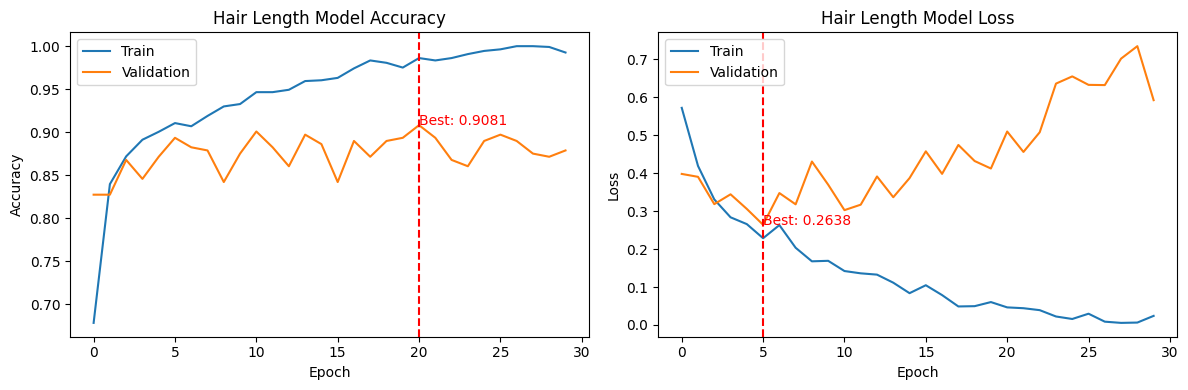

Hair Length Model - Best Validation Accuracy: 0.9081 at epoch 21
Hair Length Model - Best Validation Loss: 0.2638 at epoch 6


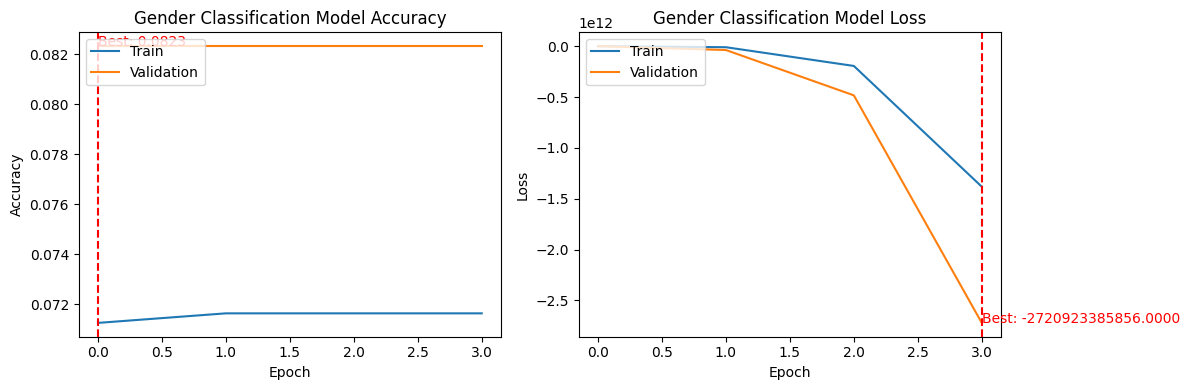

Gender Classification Model - Best Validation Accuracy: 0.0823 at epoch 1
Gender Classification Model - Best Validation Loss: -2720923385856.0000 at epoch 4


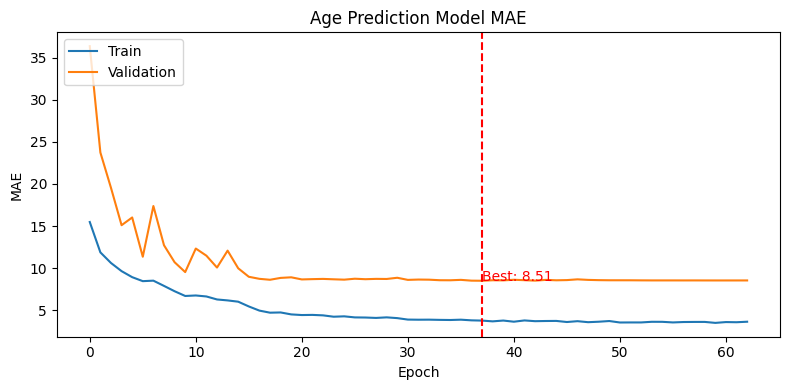

Age Prediction Model - Best Validation MAE: 8.51 at epoch 38


In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot metrics and highlight best points (similar to previous response)
def plot_training_history(history, model_name):
  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'{model_name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Highlight best validation accuracy
  best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
  best_val_acc = history.history['val_accuracy'][best_val_acc_epoch]
  plt.axvline(x=best_val_acc_epoch, color='r', linestyle='--')
  plt.text(best_val_acc_epoch, best_val_acc, f'Best: {best_val_acc:.4f}', color='r')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'{model_name} Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Highlight best validation loss
  best_val_loss_epoch = np.argmin(history.history['val_loss'])
  best_val_loss = history.history['val_loss'][best_val_loss_epoch]
  plt.axvline(x=best_val_loss_epoch, color='r', linestyle='--')
  plt.text(best_val_loss_epoch, best_val_loss, f'Best: {best_val_loss:.4f}', color='r')

  plt.tight_layout()
  plt.show()

  # Print best validation accuracy and loss
  print(f"{model_name} - Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch + 1}")
  print(f"{model_name} - Best Validation Loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch + 1}")

# Plot for hair length model
plot_training_history(hair_model_history, "Hair Length Model")

# Plot for gender classification model
plot_training_history(gender_model_history, "Gender Classification Model")

# Plot for age prediction model (MAE instead of accuracy)
def plot_age_model_history(history):
  plt.figure(figsize=(8, 4))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('Age Prediction Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Highlight best validation MAE
  best_val_mae_epoch = np.argmin(history.history['val_mae'])
  best_val_mae = history.history['val_mae'][best_val_mae_epoch]
  plt.axvline(x=best_val_mae_epoch, color='r', linestyle='--')
  plt.text(best_val_mae_epoch, best_val_mae, f'Best: {best_val_mae:.2f}', color='r')

  plt.tight_layout()
  plt.show()

  # Print best validation MAE
  print(f"Age Prediction Model - Best Validation MAE: {best_val_mae:.2f} at epoch {best_val_mae_epoch + 1}")

plot_age_model_history(age_model_history)


In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Generate predictions for metrics calculation
y_pred_hair = hair_length_model.predict(X_test_hair)
y_pred_hair = (y_pred_hair > 0.5).astype(int).flatten()

y_pred_gender = gender_classification_model.predict(X_test_gender)
y_pred_gender = (y_pred_gender > 0.5).astype(int).flatten()

# Calculate precision, recall, and F1 score for hair length classification
hair_precision = precision_score(y_test_hair, y_pred_hair, average='binary')
hair_recall = recall_score(y_test_hair, y_pred_hair, average='binary')
hair_f1 = f1_score(y_test_hair, y_pred_hair, average='binary')

print("\nHair Length Classification Metrics:")
print(f"Precision: {hair_precision:.2f}")
print(f"Recall: {hair_recall:.2f}")
print(f"F1 Score: {hair_f1:.2f}")

print("\nHair Length Classification Report:")
print(classification_report(y_test_hair, y_pred_hair))





21/21 [==============================] - 0s 5ms/step

Hair Length Classification Metrics:
Precision: 0.91
Recall: 0.90
F1 Score: 0.90

Hair Length Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       100
           1       0.91      0.90      0.90       172

    accuracy                           0.88       272
   macro avg       0.87      0.87      0.87       272
weighted avg       0.88      0.88      0.88       272



In [79]:
# Save the trained models
hair_length_model.save('hair_length_model.h5')
gender_classification_model.save('gender_classification_model.h5')
age_model.save('age_prediction_model.h5')


In [80]:
from tensorflow.keras.models import load_model

# Load the trained models
hair_length_model = load_model('hair_length_model.h5')
gender_classification_model = load_model('gender_classification_model.h5')
age_model = load_model('age_prediction_model.h5')


In [81]:
#integration code
def predict_age_hair_gender(image):
    # Preprocess the image (resize and normalize)
    img_resized = cv2.resize(image, (64, 64))
    img_normalized = img_resized / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Step 1: Predict the age
    predicted_age = age_model.predict(img_normalized)[0][0]

    # Step 2: Conditional classification based on age
    if 20 <= predicted_age <= 30:
        # If age is between 20 and 30, use the hair length model to infer gender
        predicted_hair_label = hair_length_model.predict(img_normalized)[0][0]
        gender = 'Male' if predicted_hair_label < 0.5 else 'Female'
        hair_length = 'Short' if predicted_hair_label < 0.5 else 'Long'
    else:
        # If age is outside this range, use the general gender classification model
        predicted_gender_label = gender_classification_model.predict(img_normalized)[0][0]
        gender = 'Male' if predicted_gender_label < 0.5 else 'Female'
        hair_length = 'N/A'

    return {
        'Predicted Age': predicted_age,
        'Gender': gender,
        'Hair Length': hair_length
    }


In [83]:
# Load an image
image_path = r"C:\prabhakar\null classes\long hair detection\long hair\20_1_2_20170104015722028.jpg.chip.jpg"
image = cv2.imread(image_path)

# Get predictions
predictions = predict_age_hair_gender(image)

# Print the results
print(f"Predicted Age: {predictions['Predicted Age']:.2f} years")
print(f"Gender: {predictions['Gender']}")
print(f"Hair Length: {predictions['Hair Length']}")


1/1 [==============================] - 0s 169ms/step
Predicted Age: 20.25 years
Gender: Female
Hair Length: Long


In [85]:
!pip freeze > requirements.txt


In [94]:
!python app.py


1/1 [==============================] - 6s 6s/step

1/1 [==============================] - 0s 133ms/step

1/1 [==============================] - 0s 50ms/step

1/1 [==============================] - 0s 35ms/step

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 104ms/step


2024-08-13 22:03:43.549290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 22:03:44.831528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2134 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2024-08-13 22:04:04.050308: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-08-13 22:04:05.554084: E tensorflow/core/platform/windows/subprocess.cc:287] Call to CreateProcess failed. Error code: 2, command: '"ptxas.exe" "--version"'
2024-08-13 22:04:05.555514: E tensorflow/core/platform/windows/subprocess.cc:287] Call to CreateProcess failed. Error code: 2, co

https://drive.google.com/drive/folders/1H47yHyCZnJ5A0azJbMsgl6PbkfYoPz-_?usp=drive_link